In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

In [3]:
file = pd.read_csv('dataset/TV_dataset_202511060849.csv', delimiter=';')

C:\Users\admin\AppData\Local\Temp\ipykernel_8588\3085928149.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  file = pd.read_csv('dataset/TV_dataset_202511060849.csv', delimiter=';')


In [4]:
file['GODINA'] = file['BR_OBR_PER'] // 100
file['MJESEC'] = file['BR_OBR_PER'] % 100

In [5]:
file['MJESEC_sin'] = np.sin(2 * np.pi * file['MJESEC'] / 12)
file['MJESEC_cos'] = np.cos(2 * np.pi * file['MJESEC'] / 12)

In [7]:
file2 = file[file["ID_STANA"] >= 3000000]
file2.head()

,ID_STANA,OBRACUN_ID,OBRADA_ID,BR_OBR_PER,ID_POTROS,POVRSINA,BR_OSOBA,DN_PRIM_V,MODEL_EG,MODEL_TV,...,OBRACUNATO_DANA,SNASUC,SNASTV,ENESGR,ENESTV,ENESZP,GODINA,MJESEC,MJESEC_sin,MJESEC_cos
0,424110070302,110022117043,110232521911,201010,42411007,54.25,0.0,A,2EG,NaN,...,31,0.006224,NaN,1.112,NaN,NaN,2010,10,-0.866025,0.5
1,424110070345,110022117043,110232521911,201010,42411007,30.81,0.0,A,2EG,NaN,...,31,0.003535,NaN,0.632,NaN,NaN,2010,10,-0.866025,0.5
2,424110070353,110022117043,110232521911,201010,42411007,54.25,0.0,A,2EG,NaN,...,31,0.006224,NaN,1.113,NaN,NaN,2010,10,-0.866025,0.5
3,424110070370,110022117043,110232521911,201010,42411007,30.81,0.0,A,2EG,NaN,...,31,0.003535,NaN,0.632,NaN,NaN,2010,10,-0.866025,0.5
4,424110070388,110022117043,110232521911,201010,42411007,54.25,0.0,A,2EG,NaN,...,31,0.006224,NaN,1.113,NaN,NaN,2010,10,-0.866025,0.5


In [20]:
bins = [-1, 0, 1, 2, 4, 6, np.inf]
labels = ["0", "1", "2", "3-4", "5-6", "7+"]
file2["BR_OSOBA_BIN"] = pd.cut(
    file2["BR_OSOBA"],
    bins=bins,
    labels=labels
)

In [21]:
file2["POVRSINA_BIN"] = pd.qcut(
    file2["POVRSINA"],
    q=5,
    labels=[
        "XS",
        "S",
        "M",
        "L",
        "XL"
    ]
)

In [22]:
df_EG = file2[file2["MODEL_EG"].notna()].copy()
df_TV = file2[file2["MODEL_TV"].notna()].copy()


In [17]:
nema_br_osoba_EG = df_EG[df_EG["BR_OSOBA"].isna()]
nema_br_osoba_TV = df_TV[df_TV["BR_OSOBA"].isna()]

In [24]:
df_EG = df_EG.dropna(subset=["BR_OSOBA"])
df_TV = df_TV.dropna(subset=["BR_OSOBA"])

In [28]:
features = ['POVRSINA', 'BR_OSOBA', 'MJESEC_sin', 'MJESEC_cos', 'UPBRS2EG']
X_2EG = df_EG[features].dropna()
X_2EG.head()


,POVRSINA,BR_OSOBA,MJESEC_sin,MJESEC_cos,UPBRS2EG
0,54.25,0.0,-0.866025,0.5,0.006169
1,30.81,0.0,-0.866025,0.5,0.003504
2,54.25,0.0,-0.866025,0.5,0.006169
3,30.81,0.0,-0.866025,0.5,0.003504
4,54.25,0.0,-0.866025,0.5,0.006169


In [29]:
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_2EG)

X_2EGscaled = pd.DataFrame(X_scaled_array, columns=X_2EG.columns, index=X_2EG.index)

print(X_2EGscaled.head())

   POVRSINA  BR_OSOBA  MJESEC_sin  MJESEC_cos  UPBRS2EG
0  0.031873 -0.063539   -1.255427     0.59328 -0.192929
1 -1.200182 -0.063539   -1.255427     0.59328 -0.257121
2  0.031873 -0.063539   -1.255427     0.59328 -0.192929
3 -1.200182 -0.063539   -1.255427     0.59328 -0.257121
4  0.031873 -0.063539   -1.255427     0.59328 -0.192929


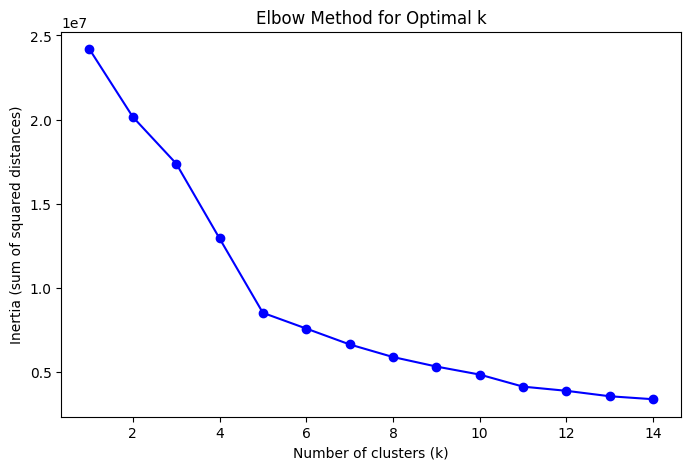

In [30]:
inertia = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_2EGscaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (sum of squared distances)')
plt.title('Elbow Method for Optimal k')
plt.show()

In [31]:
sample_indices = X_2EGscaled.sample(10000, random_state=42).index
X_sample = X_2EGscaled.loc[sample_indices]

for k in [4, 5, 6]:
    kmeans = KMeans(
        n_clusters=k, 
        random_state=42,
        n_init=10
    )
    
    labels = kmeans.fit_predict(X_2EGscaled)

    labels_sample = pd.Series(labels, index=X_2EGscaled.index).loc[sample_indices]

    score = silhouette_score(X_sample, labels_sample)
    print(f"Silhouette Score for k={k}: {score:.4f}")

Silhouette Score for k=4: 0.2995
Silhouette Score for k=5: 0.3154
Silhouette Score for k=6: 0.3046


In [36]:
k_opt = 5
kmeans = KMeans(n_clusters=k_opt, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_2EGscaled)

df_EG.loc[X_2EG.index, 'cluster1'] = labels
X_2EGscaled['cluster'] = labels

In [43]:
print(df_EG['cluster1'].value_counts())

cluster1
1.0    1754202
4.0    1649571
0.0    1422281
2.0       7896
3.0       2713
Name: count, dtype: int64


In [44]:
df_EG.loc[X_2EGscaled.index, 'cluster'] = X_2EGscaled['cluster']

columns_to_analyze = ['ENESGR', 'ENESTV', 'ENESZP']

grouped = file.groupby('cluster')[columns_to_analyze]


means = grouped.mean()
print("Prosječne vrijednosti po clusterima:")
print(means)

stds = grouped.std()
print("\nStandardna devijacija po clusterima:")
print(stds)

Prosječne vrijednosti po clusterima:
           ENESGR    ENESTV  ENESZP
cluster                            
0.0      0.251573  0.012038     NaN
1.0      1.453336  0.061841     NaN
2.0      0.973381  0.075929     NaN
3.0      1.841016  0.320420     NaN
4.0      0.951275  0.022347     NaN

Standardna devijacija po clusterima:
           ENESGR    ENESTV  ENESZP
cluster                            
0.0      0.166032  0.056759     NaN
1.0      0.701085  0.121144     NaN
2.0      0.684771  0.126420     NaN
3.0      3.203850  0.392849     NaN
4.0      0.750236  0.078582     NaN


In [46]:
print(df_EG["cluster1"].unique())

[ 1. nan  2.  3.  4.  0.]


In [53]:
features = ['POVRSINA', 'BR_OSOBA', 'MJESEC_sin', 'MJESEC_cos', 'UPBRS2EG']
target = "ENESGR"
df_EG['residual'] = np.nan
for cl in df_EG['cluster1'].unique():
    if(not cl):
       continue
    cluster_data = df_EG[df_EG['cluster1'] == cl]
    if len(cluster_data) == 0:
        print(f"Cluster {cl} je prazan, preskačem...")
        continue
    X = cluster_data[features]
    y = cluster_data[target]
    print(y)
    print(X)
    
    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    
    df_EG.loc[cluster_data.index, 'residual'] = y - y_pred

0          1.112
1          0.632
2          1.113
3          0.632
4          1.113
           ...  
5701645    1.846
5701646    1.456
5701647    0.940
5701649    0.637
5701651    1.335
Name: ENESGR, Length: 1754202, dtype: float64
         POVRSINA  BR_OSOBA    MJESEC_sin  MJESEC_cos  UPBRS2EG
0           54.25       0.0 -8.660254e-01         0.5  0.006169
1           30.81       0.0 -8.660254e-01         0.5  0.003504
2           54.25       0.0 -8.660254e-01         0.5  0.006169
3           30.81       0.0 -8.660254e-01         0.5  0.003504
4           54.25       0.0 -8.660254e-01         0.5  0.006169
...           ...       ...           ...         ...       ...
5701645     74.29       0.0 -2.449294e-16         1.0  0.010602
5701646     60.00       0.0 -2.449294e-16         1.0  0.012072
5701647     34.00       0.0 -2.449294e-16         1.0  0.009403
5701649     37.05       0.0 -2.449294e-16         1.0  0.008744
5701651     44.30       1.0 -2.449294e-16         1.0  0.005201

In [54]:
df_EG['residual_z'] = df_EG.groupby('cluster')['residual'].transform(lambda x: zscore(x, ddof=0))

# Flag za anomalije
df_EG['anomaly'] = df_EG['residual_z'].abs() > 3 

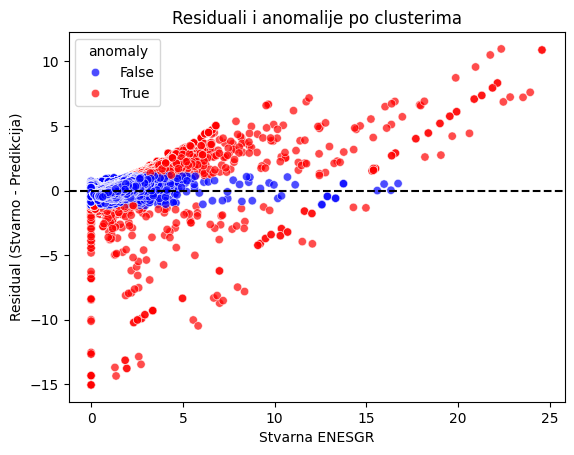

Cluster nan je prazan, preskačem...


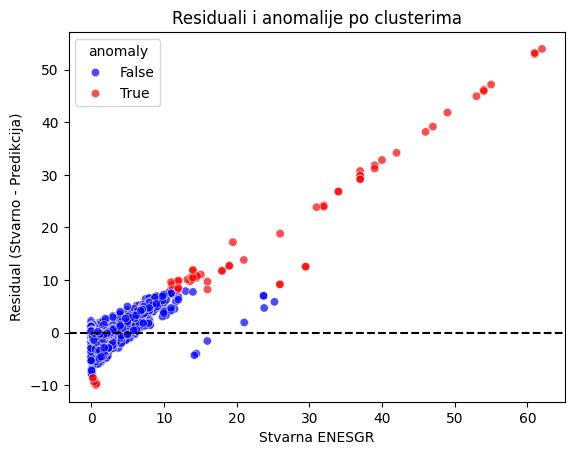

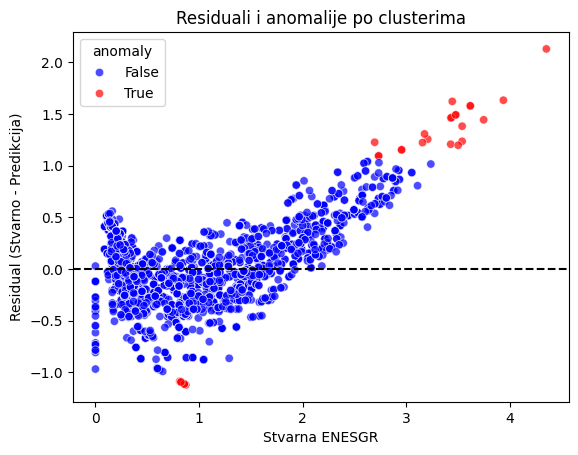

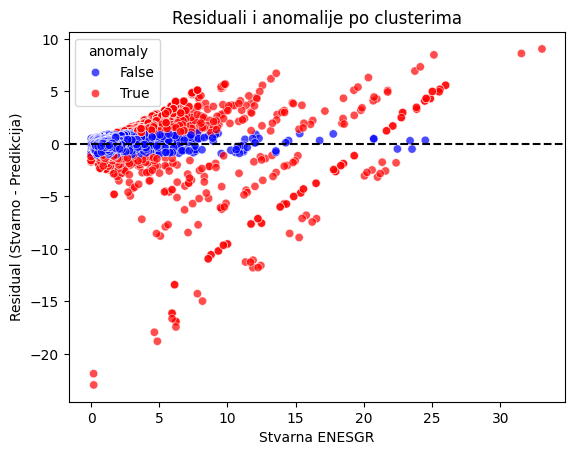

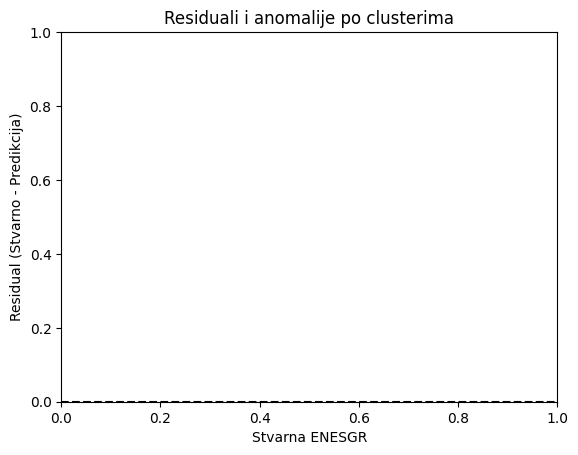

In [57]:
i = 1
for cl in df_EG['cluster1'].unique():
   cluster_data = df_EG[df_EG['cluster1'] == cl]
   if len(cluster_data) == 0:
        print(f"Cluster {cl} je prazan, preskačem...")
        continue
   plt.figure(i)
   i+=1
   sns.scatterplot(
    x='ENESGR',          # stvarna energija grijanja
    y='residual',        # stvarno - predikcija
    hue='anomaly',       # True/False
    
    palette={True:'red', False:'blue'},
    alpha=0.7,
    data=df_EG[df_EG["cluster1"]==cl]
   )
   plt.axhline(0, color='black', linestyle='--')  # residuali = 0
   plt.xlabel('Stvarna ENESGR')
   plt.ylabel('Residual (Stvarno - Predikcija)')
   plt.title('Residuali i anomalije po clusterima')
   plt.show()
   


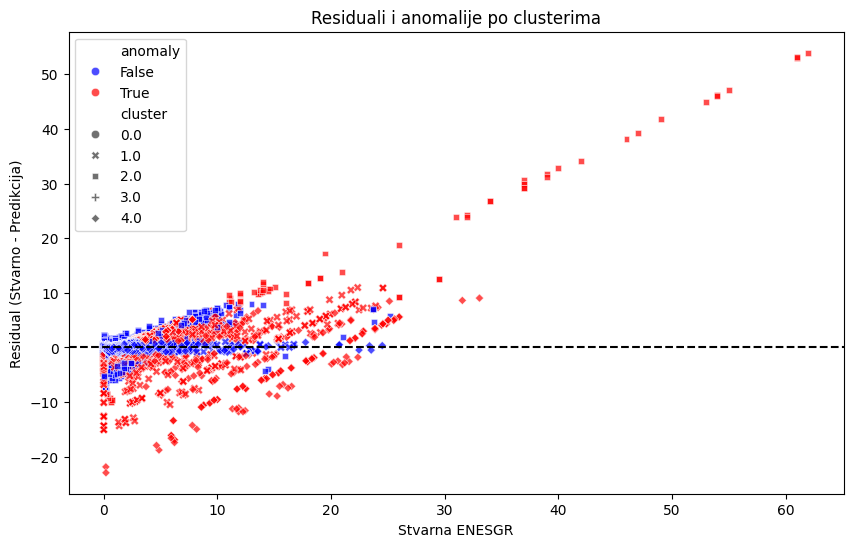

In [56]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x='ENESGR',          # stvarna energija grijanja
    y='residual',        # stvarno - predikcija
    hue='anomaly',       # True/False
    style='cluster',     # opcionalno: cluster
    palette={True:'red', False:'blue'},
    alpha=0.7,
    data=df_EG
)
plt.axhline(0, color='black', linestyle='--')  # residuali = 0
plt.xlabel('Stvarna ENESGR')
plt.ylabel('Residual (Stvarno - Predikcija)')
plt.title('Residuali i anomalije po clusterima')
plt.show()

In [35]:
features = ['POVRSINA', 'BR_OSOBA', 'MJESEC_sin', 'MJESEC_cos', 'UPSRS3EG','UISRS3EG']
X_3EG = file[features].dropna()
X_3EG.head()

,POVRSINA,BR_OSOBA,MJESEC_sin,MJESEC_cos,UPSRS3EG,UISRS3EG
8183,54.36,0.0,-0.866025,0.5,0.033360,0.004730
8184,54.36,0.0,-0.866025,0.5,0.033360,0.039479
8185,54.36,0.0,-0.866025,0.5,0.033360,0.001110
8186,52.21,0.0,-0.866025,0.5,0.032041,0.030252
8187,54.36,0.0,-0.866025,0.5,0.033360,0.010979


In [ ]:
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X_3EG)

X_3EGscaled = pd.DataFrame(X_scaled_array, columns=X_3EG.columns, index=X_3EG.index)

print(X_3EGscaled.head())